# **Final model**

## **Table of contents**

* [Our goals](#Our-goals)
* [Building the final pipeline](#Building-the-final-pipeline)
* [Tuning the hyperparameters](#Tuning-the-hyperparameters)
* [Testing the model](#Testing-the-model)
* [Features importance and interpretability](#Features-importance-and-interpretability)
* [Tuning the threshold](#Tuning-the-threshold)
* [Summary](#Summary)

In [9]:
import sys
import os
from pathlib import Path

project_root = str(Path(os.getcwd()).parent)
if project_root not in sys.path:
    sys.path.append(project_root)

from utilities import (
    final_features,
    plot_utilities
)

from utilities.final_features import (
    JoinDataFrame,
    RemoveAnomalieRescaleAndDrop,
    CustomImputer,
    CustomPCATransformer,
    FeatureEngineering,
    CustomScaler,
    CustomPolynomialTransformer,
    CustomTargetEncoder
)
from utilities.plot_utilities import Rstyle_spines

import joblib

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from sklearn import set_config

set_config(transform_output="pandas")
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

from lightgbm import LGBMClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import DeltaXStopper

def on_step(optim_result):
    print(f"Iteration {len(optim_result.x_iters)}")
    return False


import shap

from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

## **Our goals**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
In this notebook, we will:

* **Update the Previous Pipeline:**
    * Incorporate our previous work into the pipeline.
    * Simplify feature creation functions based on the results of the recursive feature selection, reducing complexity while maintaining performance.
* **Tune the Final Model Hyperparameters:**
    * Use Bayesian optimization to fine-tune the hyperparameters of our chosen model, aiming to maximize its performance.
* **Test the Model and Evaluate Performance:**
    * Assess the model's performance on the validation set.
    * Provide a detailed analysis of its strengths and weaknesses.
* **Comment on the model features and their importance:**
    * Try to understand what are key features in loan default prediction
* **Develop an Initial Strategy for Threshold Optimization:**
    * Explore how adjusting the classifier threshold can optimize Home Credit's gains.
    * Outline a preliminary strategy for implementing this optimization in practice.
</div>

In [10]:
train = pd.read_parquet("../app_data/application_train.parquet")
X_train = train.drop("TARGET", axis=1)
y_train = train["TARGET"]
skf = StratifiedKFold(n_splits=3, shuffle=True)
add_dir = "../add_data/"

## **Building the final pipeline**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
In this section, we will bring together all the elements we've developed so far to build our final model pipeline. This pipeline will be the one we eventually deploy, so we've focused on optimizing every aspect of it for maximum efficiency and performance.
</div>

In [11]:
final_pipeline = Pipeline(
    [
        ("joiner", JoinDataFrame(add_dir)),
        ("remover", RemoveAnomalieRescaleAndDrop()),
        ("imputer", CustomImputer()),
        ("scaler", CustomScaler()),
        ("PCA_transformer", CustomPCATransformer()),
        ("feature_engineering", FeatureEngineering()),
        ('poly', CustomPolynomialTransformer()),
        ('encoder', CustomTargetEncoder()),
        ("lightgbm", LGBMClassifier(class_weight="balanced", verbose=-1, objective="binary"))
    ]
)

In [4]:
scores = cross_validate(
    final_pipeline,
    X_train,
    y_train,
    cv=skf,
    scoring="roc_auc",
    return_train_score=True,
    n_jobs=4,
)

In [5]:
train_score = scores["train_score"].mean()
test_score = scores["test_score"].mean()
print(f"train_score = {train_score} \ntest_score = {test_score}")

train_score = 0.8225469474630428 
test_score = 0.7596313386082847


In [6]:
test = pd.read_parquet("../app_data/application_test.parquet")
X_test = test.drop("TARGET", axis=1)
y_test = test["TARGET"]

## **Tuning the hyperparameters**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
Now, it’s time to tune the hyperparameters using Bayesian optimization with 30 iterations. While this process will take around an hour, it's important to note that excessive hyperparameter tuning can sometimes result in overfitting, potentially decreasing the model's performance on unseen data. Therefore, we'll aim to strike a balance between optimization and generalization.
</div>

In [7]:
%%skip
%%time
param_space = {
    'lightgbm__num_leaves': Integer(10, 100),
    'lightgbm__max_depth': Integer(3, 10),
    'lightgbm__learning_rate': Real(0.01, 1.0, prior='log-uniform'),
    'lightgbm__n_estimators': Integer(50, 300),
    'lightgbm__min_child_samples': Integer(1, 100),
    'lightgbm__subsample': Real(0.1, 1.0, prior='uniform'),
    'lightgbm__colsample_bytree': Real(0.1, 1.0, prior='uniform'),
    'lightgbm__reg_alpha': Real(1e-8, 10.0, prior='log-uniform'),
    'lightgbm__reg_lambda': Real(1e-8, 10.0, prior='log-uniform'),
}

bayes_search = BayesSearchCV(
    estimator=final_pipeline,
    search_spaces=param_space,
    n_iter=30,  
    cv=skf,  
    n_jobs=4,  
    verbose=0,
    scoring='roc_auc',
    random_state=42,
    optimizer_kwargs={'base_estimator': 'GP'},  
)

# Fit the model
bayes_search.fit(X_train, y_train, callback=[on_step])
lgm_best = bayes_search.best_estimator_
joblib.dump(lgm_best, '../pkl/lgbm_best.joblib')

In [12]:
lgbm_best = joblib.load("../pkl/lgbm_best.joblib")

In [9]:
test = pd.read_parquet("../app_data/application_test.parquet")
X_test = test.drop("TARGET", axis=1)
y_test = test["TARGET"]
lgbm_pred_probs = lgbm_best.predict_proba(X_test)[:, 1]
lgbm_pred = lgbm_best.predict(X_test)

## **Testing the model**

Text(0.5, 0.98, 'LGBM final performance')

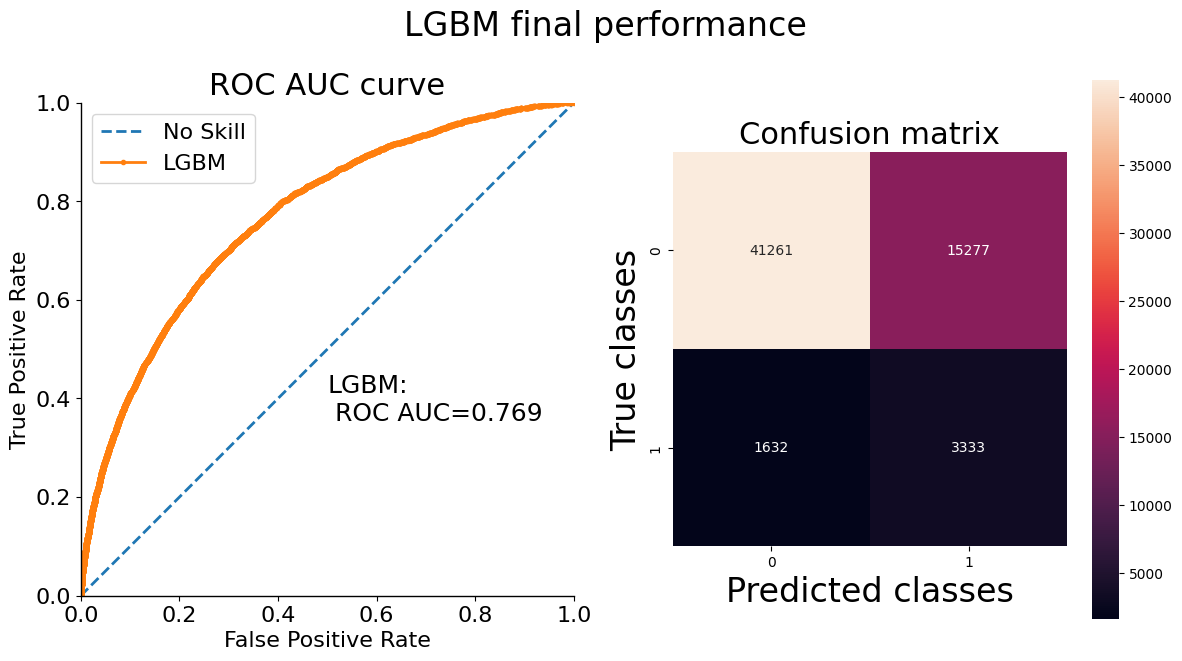

In [13]:
ns_probs = [0 for _ in range(len(y_test))]

ns_auc = roc_auc_score(y_test, ns_probs)
lgbm_auc = roc_auc_score(y_test, lgbm_pred_probs)

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_pred_probs)
axs[0].plot(ns_fpr, ns_tpr, linestyle="--", label="No Skill", lw=2)
axs[0].plot(lgbm_fpr, lgbm_tpr, marker=".", label="LGBM", lw=2)
axs[0].text(
    0.5,
    0.45,
    f"LGBM:\n ROC AUC={lgbm_auc:.3f}",
    transform=axs[0].transAxes,
    fontsize=18,
    verticalalignment="top",
)
axs[0].set_xlim([0, 1])
axs[0].set_ylim([0, 1])
Rstyle_spines(axs[0], lw=1)
axs[0].tick_params(axis="both", labelsize=16)
axs[0].set_xlabel("False Positive Rate", fontsize=16)
axs[0].set_ylabel("True Positive Rate", fontsize=16)
axs[0].legend(fontsize=16)
axs[0].set_title("ROC AUC curve", fontsize=22)
axs[0].set_aspect("equal")

sns.heatmap(confusion_matrix(y_test, lgbm_pred), ax=axs[1], annot=True, fmt="d")
axs[1].set_xlabel("Predicted classes", fontsize=24)
axs[1].set_ylabel("True classes", fontsize=24)
axs[1].set_title("Confusion matrix", fontsize=22)
axs[1].set_aspect("equal")

fig.suptitle("LGBM final performance", fontsize=24)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
The final ROC-AUC score of our model is 0.769. As anticipated, hyperparameter tuning led to a marginal improvement in the model's performance, which can still have significant implications for this task. Examining the confusion matrix on the right, we observe that our model produces a considerable number of false positives—rejecting loan applications from applicants who ultimately would not default. However, the number of false negatives, where the model accepts applications that later default, is not excessively high.
</div>

## **Features importance and interpretability**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
Now that we have our final model, we can gain insights into which features are most relevant in predicting whether a loan applicant will default. To do this, we'll use the native feature importance function within LightGBM.

This function measures the importance of each feature by assessing how much it contributes to reducing the loss function during model training. Every time a feature is used to split the data in a decision tree, it reduces the loss function (e.g., Gini impurity). The feature importance score is the accumulated amount of loss reduction associated with each feature across all the trees in the model. This will help us identify which features have the most significant impact on our model's predictions.

Additionally, we'll use also shap feature importance analysis. This is a game theory based algorithm that help dressing features importance. It is a good complement to LightGBM importance features, and it is always interesting to compare both results.
</div>

In [16]:
lgbm_classifier = lgbm_best.named_steps["lightgbm"]
features_out = lgbm_best.named_steps['encoder'].get_feature_names_out()
feature_imp = pd.DataFrame(
    sorted(zip(lgbm_classifier.feature_importances_, features_out)),
    columns=["Value", "Feature"],
)

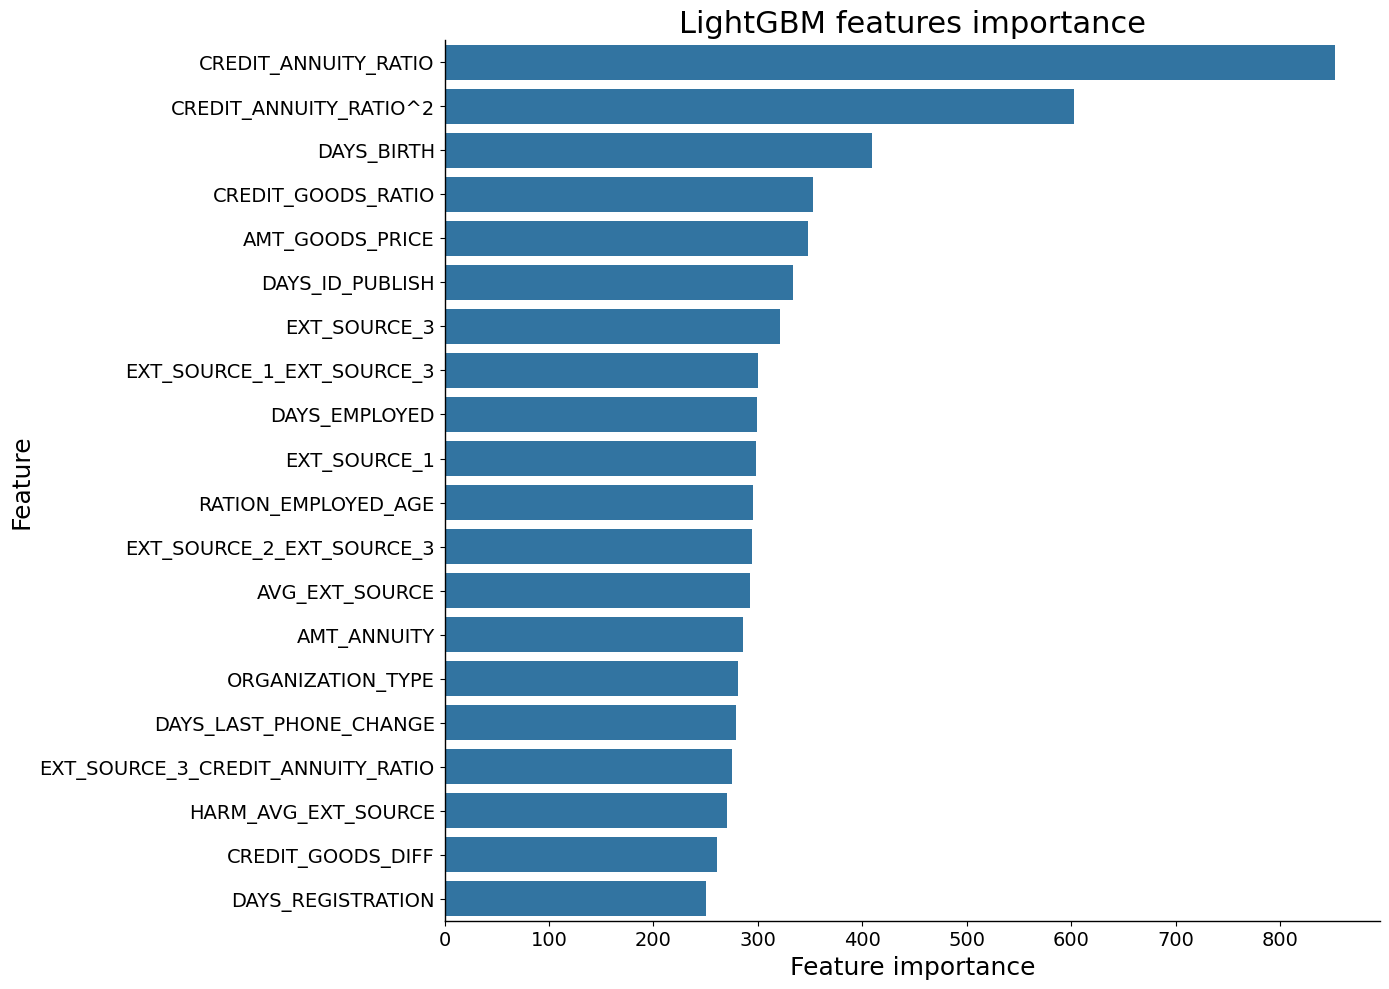

In [17]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.barplot(
    x="Value",
    y="Feature",
    data=feature_imp.sort_values(by="Value", ascending=False)[:20],
    ax=ax,
)
ax.set_title("LightGBM Features (avg over folds)")
ax.set_xlabel("Feature importance", fontsize=18)
ax.set_ylabel("Feature", fontsize=18)
ax.set_title("LightGBM features importance", fontsize=22)
Rstyle_spines(ax, lw=1)
ax.tick_params(axis="both", which="major", labelsize=14)
plt.tight_layout()
plt.show()

In [20]:
%%skip
explainer = shap.TreeExplainer(lgbm_best.named_steps["lightgbm"])
joblib.dump(explainer, "../pkl/shap_explainer.joblib")

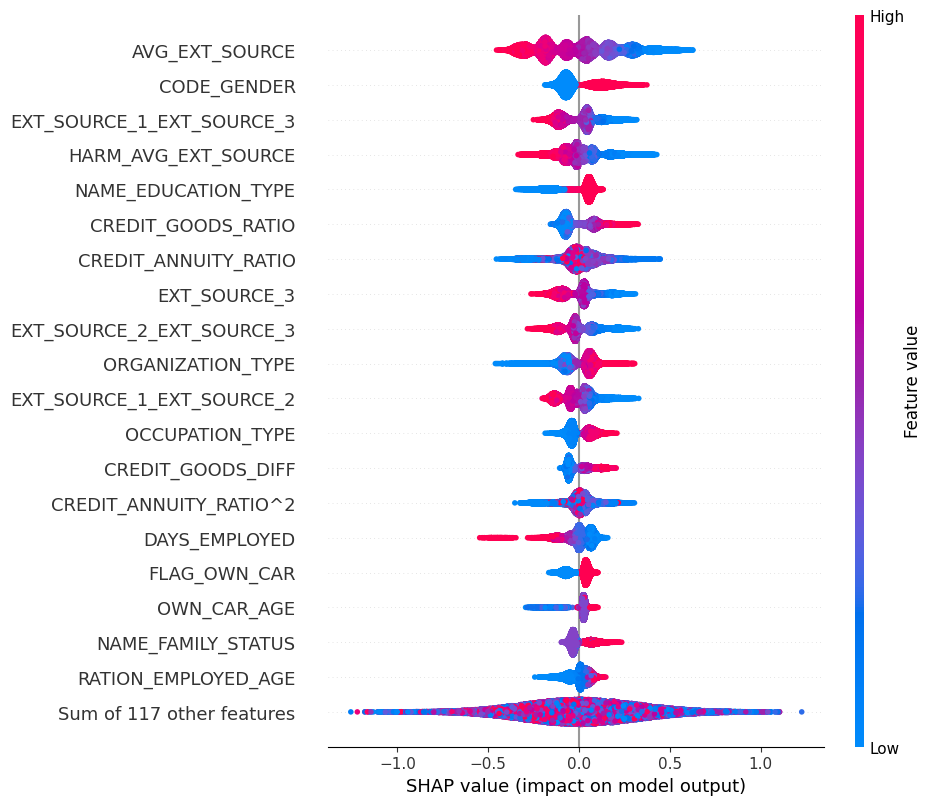

In [21]:
preprocessor = Pipeline(lgbm_best.steps[:-1])
X_test_enc = preprocessor.transform(X_test)
explainer = joblib.load("../pkl/shap_explainer.joblib")
shap_values = explainer(X_test_enc)
shap.plots.beeswarm(shap_values[:, :, 1], max_display=20)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
We have selected the top 20 most important features from our model, and the first observation is the noticeable differences between the feature importance rankings returned by SHAP and LightGBM. For instance, while SHAP places gender among the top 3 most important features, it doesn't even appear in the top 20 according to LightGBM's feature importance module.

However, one consistent finding is that the `CREDIT_ANNUITY_RATIO` and any `EXT_SOURCE`-related features are of major importance across both methods. Interestingly, none of the features we engineered from the additional datasets appear in either the LightGBM or SHAP rankings. This suggests that the application form alone contains most of the essential information needed to predict whether a loan applicant is likely to default.
</div>

## **Tuning the threshold**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
To conclude our journey, we'll tune the threshold that determines whether, given a default probability, we'll accept or reject a loan application. This decision-making process is similar to betting: accepting a loan application implies that, based on the odds, we believe the company will profit from the loan. We can transform this into an optimization problem using the following setup:

**Problem Setup:**
* **Loan Value (`x`):** A loan applicant requests a loan of value `x` (`AMT_CREDIT`).
* **Interest Rate (`r`):** Depending on the loan type (revolving, consumer, mortgage, etc.), Home Credit establishes a repayment scheme. For simplicity, we'll assume a simple percentage interest rate. For example, a mortgage might have a 4% interest rate.
* **Gain from Non-Default:** If the loan applicant does not default and repays the loan, Home Credit will gain `r` * `x`.
* **Loss from Default (`z`):** If the loan applicant defaults, Home Credit will lose money. The percentage of the total credit amount recovered is called the loan recovery rate, denoted by `z`. Thus, the loss in case of default will be (1-`z`) * `x`.

**Using Public Data:**
Since we don't have access to the exact recovery amounts, we'll rely on [public data](https://www.spglobal.com/ratings/en/research/articles/231215-default-transition-and-recovery-u-s-recovery-study-loan-recoveries-persist-below-their-trend-12947167). For instance, a recent 2023 article by S&P Global provides statistics related to recovery rates. We can use this information to optimize the potential gain by tuning our model's threshold.

**Approach:**
* **Set a Threshold:** Start with a threshold value, say 0.3.
* **Estimate `r` and `y` Based on Loan Type:**
    * **Cash Loans:**
        * **Average interest rate `r`:** 12%
        * **Typical recovery rate `y`:** 50%
    * **Revolving Loans:**
        * **Average interest rate `r`:** 20%
        * **Recovery rate `y`:** 95%
* **Calculate Gain/Loss:**
    * If the loan applicant does not default, add `r` * `x` to Home Credit's gain.
    * If the loan applicant defaults, subtract (1-`z`) * `x` from the gain.
* **Iterate Over Multiple Thresholds:** Repeat the above steps for various threshold values and determine the one that maximizes Home Credit's gains.

**Next Steps:**
* Implement the calculation using the test set predictions.
* Optimize the threshold based on the expected financial outcomes.
</div>

In [22]:
data = X_test[["AMT_CREDIT", "NAME_CONTRACT_TYPE"]].copy()
data["proba"] = lgbm_pred_probs
data["rate"] = np.where(
    data["NAME_CONTRACT_TYPE"] == "Cash loans",
    0.12,
    np.where(data["NAME_CONTRACT_TYPE"] == "Revolving loans", 0.2, 0),
)
data["recovery"] = np.where(
    data["NAME_CONTRACT_TYPE"] == "Cash loans",
    0.5,
    np.where(data["NAME_CONTRACT_TYPE"] == "Revolving loans", 0.95, 0),
)

thresholds = np.arange(0, 1, 0.01)
gain = []
for threshold in thresholds:
    data["decision"] = (lgbm_pred_probs > threshold).astype("int")
    g = (
        data["AMT_CREDIT"]
        * data["decision"]
        * (data["rate"] * (1 - y_test) - (1 - data["recovery"]) * y_test)
    ).sum()
    gain.append(g)

Text(0.5, 1.0, 'Optimizing Home Credit profit')

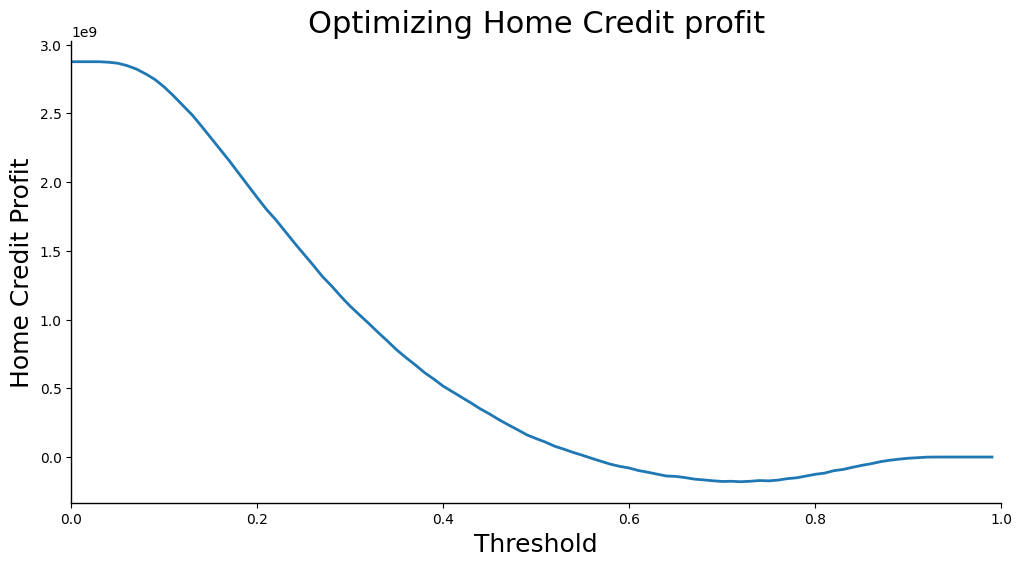

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(thresholds, gain, lw=2)
ax.set_xlim((0, 1))
Rstyle_spines(ax, lw=1)
ax.set_xlabel("Threshold", fontsize=18)
ax.set_ylabel("Home Credit Profit", fontsize=18)
ax.set_title("Optimizing Home Credit profit", fontsize=22)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
If we follow the results presented above, it appears that Home Credit would actually benefit from approving every loan application. This conclusion arises because the gains from valid applicants seem to outweigh the losses from defaulters. However, before making such a sweeping decision, we must recognize that this model is overly simplistic. Several factors should be considered to avoid an overly risky strategy:

**Why a Blanket Approval Strategy is Risky:**
* **Risk Accumulation:** Approving all loans would likely lead to a high concentration of high-risk loans, which could ultimately threaten the lender's solvency. Losses from defaulting loans, even with a high recovery rate, could accumulate over time.
* **Reputation Risk:** A high default rate, even if profitable in the short term, could damage Home Credit's reputation and credit rating. This could make it harder to access capital or attract new customers.

**Steps Forward:**
Although this simple model shows potential for profit optimization, further steps are essential:
* **Access More Data:** We need access to the loan application data, including interest rates and full annuity schedules. This would help us refine the model and account for the actual loan repayment structure, providing a more realistic assessment.
* **Consider a More Sophisticated Profit Optimization Scheme:** We should factor in the loan applicant profile more granularly, adjusting the repayment scheme and risk assessments accordingly. Optimizing the reimbursement scheme based on individual profiles could allow for a more balanced and informed decision-making process.

While we've simplified things here, this could be a valuable first step toward a more advanced profit optimization strategy. By incorporating these additional complexities, Home Credit could potentially design a more robust model that carefully balances risk and reward.
</div>

## **Summary**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
In this notebook, we have:

* Simplified our model pipeline by leveraging the insights from recursive feature selection, leading to a more efficient and focused approach.
* Optimized our model through hyperparameter tuning, ensuring the best possible performance.
* Explored the model's key features and their impact on the prediction outcomes. We observed significant differences between the feature importance rankings from LightGBM and SHAP, with application form features emerging as the most crucial across both estimators.
* Proposed a business-oriented strategy to adjust the model's probability threshold. While the simplified model suggested that Home Credit could maximize profits by accepting all loan applications, this approach is impractical. However, it does provide a starting point for developing a more refined and consistent business strategy.

</div>